Learn to predict the number of real solutions of the tritangent circles to three conics.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
import numpy as np

In [2]:
# Import Data
path = '/Users/las/Documents/GitHub/REU/hill_climb_w_solution_counts.xlsx'
df = pd.read_excel(path)
data = df[[col for col in df.columns if col[0].isupper()]].rename(str.lower, axis='columns')
df.head()

,a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,...,B4,B5,B6,C1,C2,C3,C4,C5,C6,Counts
0,0.080945,0.360232,0.057056,0.749259,0.955720,0.807542,0.632065,0.987198,0.858777,0.747515,...,1.009519,0.753096,0.486770,-0.004601,0.190029,0.265888,0.167961,0.726625,0.297465,26
1,0.020657,0.528250,0.785039,0.140394,0.629471,0.232232,0.442754,0.177439,0.541098,0.378114,...,0.461198,0.016416,0.170428,0.486811,0.728032,0.885663,0.050032,0.648216,0.157806,0
2,0.524718,0.271188,0.617312,0.352435,0.446476,0.870586,0.790443,0.930621,0.314740,0.650593,...,0.638183,0.010259,-0.030974,0.778479,1.059313,0.434567,0.503703,0.603667,0.192912,10
3,0.391623,0.766953,0.151090,0.986174,0.769373,0.199420,0.685867,0.058377,0.051811,0.073706,...,0.064034,0.401679,0.929817,0.090694,0.480075,0.301884,0.614086,0.812183,0.725908,20
4,0.914580,0.289532,0.338711,0.269049,0.688129,0.896449,0.850288,0.451521,0.327267,0.763946,...,0.408069,0.124350,-0.231770,0.388754,0.696648,0.785599,0.885972,0.387142,0.583846,8


In [16]:
# Create Training and Validation Data
count = np.array(data['counts'].values.tolist(), dtype=np.int)/2
param = np.array(data.drop('counts', axis=1).values.tolist(), dtype=np.float64)
n = int(0.8*len(count))

count_train, count_val = count[:n], count[n:]
param_train, param_val = param[:n], param[n:]

/Users/las/opt/anaconda3/envs/REU/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [17]:
# Set Up Network Architecture
model = keras.Sequential([
    keras.layers.Dense(units=1000, activation='relu', input_shape=(18,)),
    keras.layers.Dense(units=1000, activation='relu'),
    keras.layers.Dense(units=69, activation='softmax')
])

model.summary()

2022-08-20 12:58:22.966788: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-20 12:58:22.967216: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              19000     
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_2 (Dense)              (None, 69)                69069     
Total params: 1,089,069
Trainable params: 1,089,069
Non-trainable params: 0
_________________________________________________________________


In [18]:
sce = keras.losses.SparseCategoricalCrossentropy()
es = tf.keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_crossentropy", patience=3)
model.compile(optimizer='Adam', 
              loss=sce,
              metrics=['accuracy', sce],
              callbacks=[es])

In [19]:
# Train model
history = model.fit(param_train,
                    count_train,
                    verbose=2,
                    epochs=15,
                    batch_size=64,
                    validation_data=(
                        param_val,
                        count_val
                    )
)

Train on 80000 samples, validate on 20000 samples
Epoch 1/15
80000/80000 - 64s - loss: 2.5006 - accuracy: 0.1644 - sparse_categorical_crossentropy: 2.5006 - val_loss: 2.3880 - val_accuracy: 0.1980 - val_sparse_categorical_crossentropy: 2.3880
Epoch 2/15
80000/80000 - 62s - loss: 2.3283 - accuracy: 0.2122 - sparse_categorical_crossentropy: 2.3283 - val_loss: 2.1943 - val_accuracy: 0.2607 - val_sparse_categorical_crossentropy: 2.1942
Epoch 3/15
80000/80000 - 55s - loss: 2.0989 - accuracy: 0.2963 - sparse_categorical_crossentropy: 2.0989 - val_loss: 1.8824 - val_accuracy: 0.3843 - val_sparse_categorical_crossentropy: 1.8823
Epoch 4/15
80000/80000 - 54s - loss: 1.7664 - accuracy: 0.4195 - sparse_categorical_crossentropy: 1.7663 - val_loss: 1.4904 - val_accuracy: 0.5196 - val_sparse_categorical_crossentropy: 1.4902
Epoch 5/15
80000/80000 - 54s - loss: 1.3769 - accuracy: 0.5655 - sparse_categorical_crossentropy: 1.3769 - val_loss: 1.0781 - val_accuracy: 0.6722 - val_sparse_categorical_crosse

[]

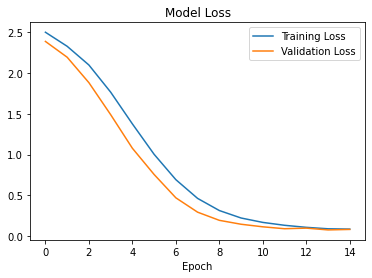

In [20]:
# Graphs
fig = plt.figure()
plt.title('Model Loss')
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.plot()

[]

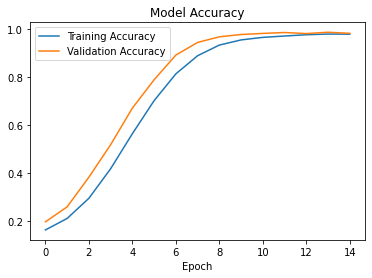

In [21]:
# Graphs
fig = plt.figure()
plt.title('Model Accuracy')
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.plot()

In [51]:
# import pickle
# keras.models.save_model(model, "model_1000_1000_69_v2.h5")
# np.save('history.npy', history.history)
# model = keras.models.load_model("/Users/las/Documents/GitHub/REU/model_1000_1000_136_v2.h5", compile=False)

In [ ]:
# data = data.drop('prediction', axis=1)
predictions = 2*np.argmax(model.predict(param), axis=1)
data.insert(19, 'predictions', predictions)

<AxesSubplot:>

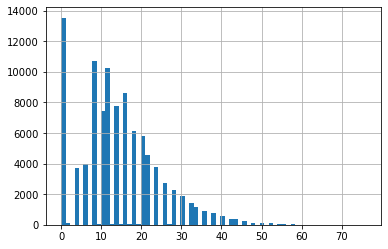

In [22]:
data.counts.hist(bins=69)

In [3]:
data.predictions.hist(bins=69)

AttributeError: 'DataFrame' object has no attribute 'predictions'

In [ ]:
#TODO print confusion matrix
# matrix = tf.math.confusion_matrix(data.counts, data.predictions)
# for i, line in enumerate(matrix):
#    print(i, line)

0.08158


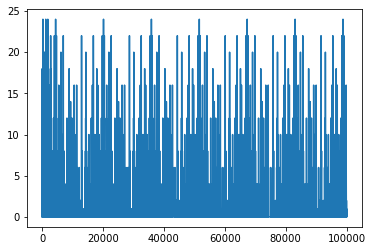

In [ ]:
delta = abs(np.array(data.counts[:]) - np.array(data.predictions[:]))
plt.plot(delta)
print(sum(delta)/len(delta))

In [ ]:
res = []
for val in [2*i for i in range(0, 68)]:
    n = len(data[data.counts == val])
    m = len(data[data.predictions == val])
    print(res.append([val, m , n, abs(n-m), abs(m-n)/(m+n+1)]))

0 13508 13529 21 0.0007766846660255937
2 137 136 1 0.0036496350364963502
4 3695 3723 28 0.0037740935436042593
6 3900 3983 83 0.010527650938609842
8 10853 10713 140 0.006491398896462187
10 7370 7403 33 0.0022336537159875457
12 10332 10272 60 0.002911914583838874
14 7820 7783 37 0.0023711868751602155
16 8738 8633 105 0.006044209072069998
18 6051 6112 61 0.005014797763893456
20 5746 5777 31 0.002690038181187088
22 4736 4533 203 0.021898597626752968
24 3809 3745 64 0.008471211118464593
26 2738 2735 3 0.0005480453050785532
28 2320 2300 20 0.004328067517853278
30 1875 1858 17 0.0045527584359935725
32 1418 1418 0 0.0
34 1129 1143 14 0.0061592608886933565
36 900 878 22 0.012366498032602586
38 769 773 4 0.002592352559948153
40 559 546 13 0.011754068716094032
42 404 410 6 0.007361963190184049
44 398 399 1 0.0012531328320802004
46 257 256 1 0.0019455252918287938
48 137 137 0 0.0
50 95 95 0 0.0
52 96 96 0 0.0
54 46 46 0 0.0
56 45 45 0 0.0
58 43 43 0 0.0
60 13 13 0 0.0
62 12 12 0 0.0
64 19 19 0 0.0

In [10]:
import numpy as np
history = np.load('history.npy', allow_pickle=True)

In [13]:
history

array({'loss': [2.5028622484207155, 2.322300371456146, 2.0976111087799074, 1.7577059029579163, 1.366722566127777, 0.9962014091491699, 0.6880710859537125, 0.4653830115437508, 0.31660484182834625, 0.22426726942658423, 0.16605374188125133, 0.13380926387310027, 0.11154565028846264, 0.08980413594394922, 0.08414098197817803, 0.07417063783705234, 0.07211762104928493, 0.06680345515869558, 0.06466763180941343, 0.061684722450003025, 0.05577682900168002, 0.06205605303645134, 0.05521667308807373, 0.060393981457687915, 0.05253542554285377, 0.05283835794739425, 0.054265765951760116, 0.04985613180361688, 0.05143738014595583, 0.050615464605763556, 0.04628799647856504, 0.04526296303551644, 0.05204817963577807, 0.048158413049206136, 0.0487504192086868, 0.0414596162349917, 0.0455415250194259, 0.048855797766521575, 0.04233593120262958, 0.04180782137271017, 0.045316125523205845, 0.04275474466746673, 0.04477754922835157, 0.0390960831375327, 0.04412909241141751, 0.036607817665860055, 0.042093037618463856, 0.